In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split,cross_validate, KFold, StratifiedKFold, GridSearchCV # 학습, 테스트set 구분
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

import warnings
warnings.filterwarnings('ignore')

In [2]:
df  = pd.read_csv('/content/drive/MyDrive/Dacon/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Dacon/test.csv')

# 데이터 전처리

In [3]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = df.drop(['index', 'country'], axis=1).copy()

In [4]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2.314232,1.703024,1.346018,1.185113,4.098340,1.847956,1.633121,1.179917,1.938703
std,0.916050,0.552935,0.474969,0.481237,3.397606,1.206812,0.480602,0.464709,0.239170
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,2.000000,1.000000,2.000000
max,4.000000,3.000000,2.000000,3.000000,12.000000,5.000000,2.000000,3.000000,2.000000


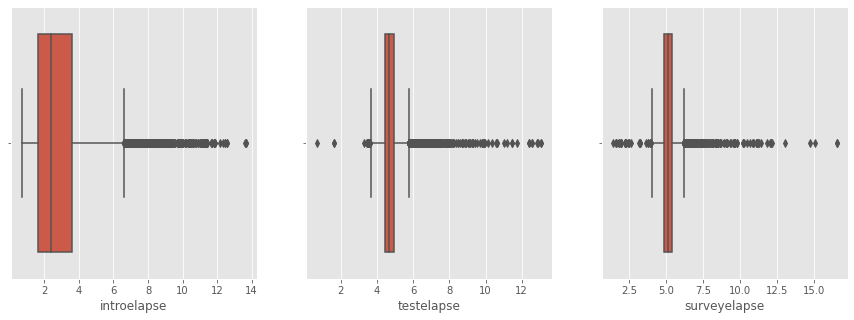

In [5]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [6]:
# Ranging and Ordinary Encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data[['age']])
processed_data['age'].value_counts()

0.0    6824
1.0    5161
2.0    1493
3.0     822
4.0     459
5.0     202
6.0      28
9.0       7
7.0       3
8.0       1
Name: age, dtype: int64

count    15000.000000
mean         2.298851
std          0.836876
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


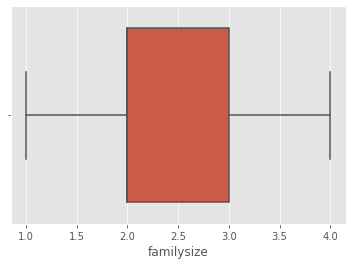

In [7]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

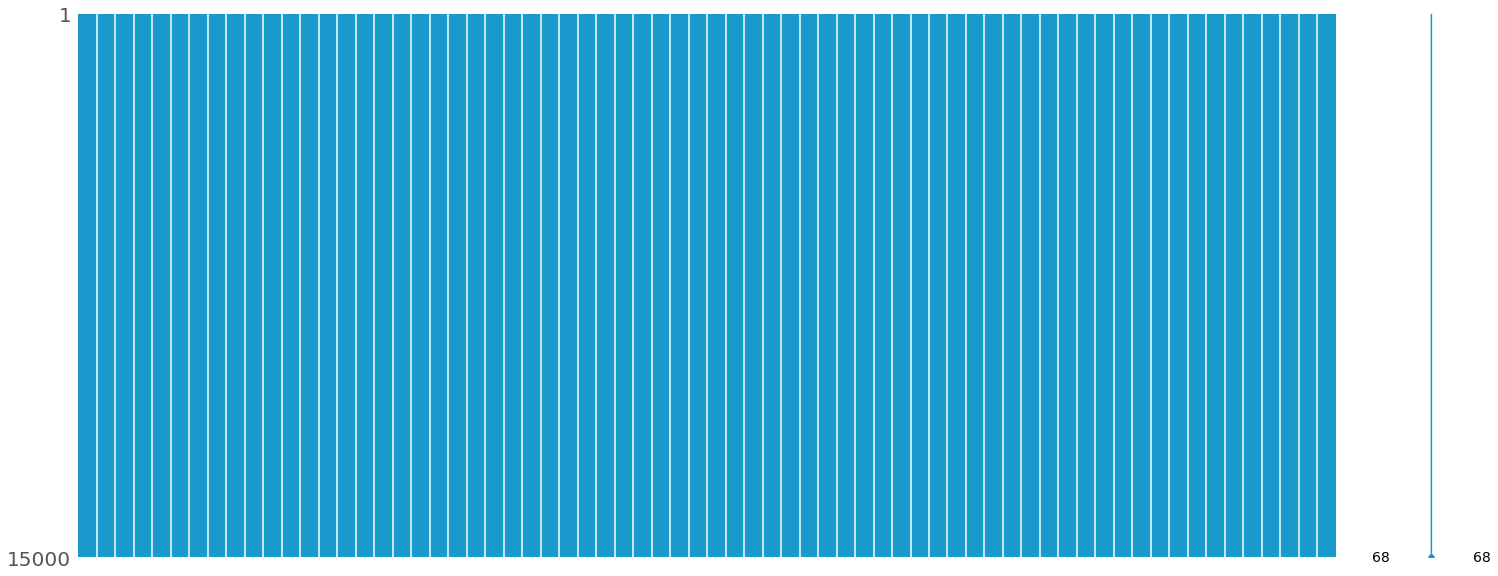

In [8]:
# finish handling missing values! 
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
nomach_cols = ['Q{}'.format(i) for i in range(21,27)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

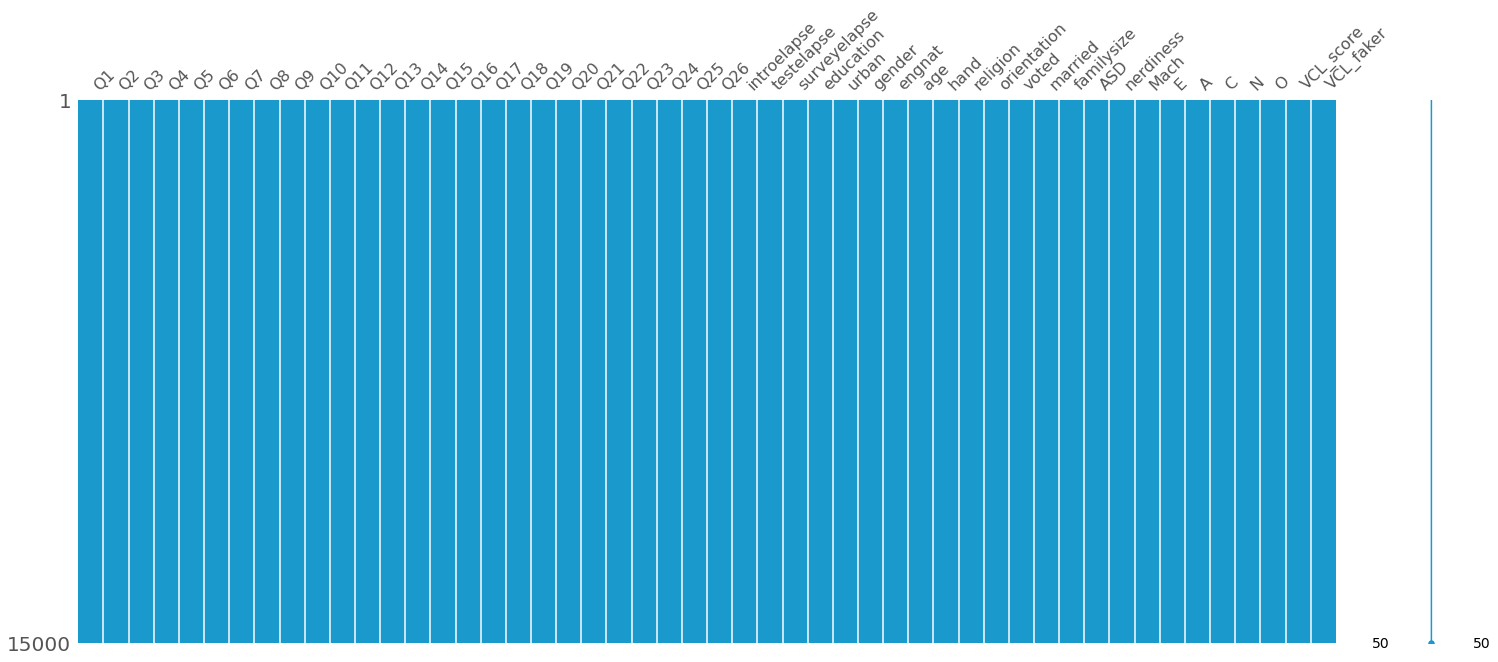

In [9]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

train = processed_data.copy()

In [10]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 

# Feature drop : 'index'
test = test.drop(['index', 'country'], axis=1).copy()

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
test[fill_cols] = transformer.fit_transform(test[fill_cols])
test[fill_cols].describe()

# labeling the other countries as 1 
#df_country = pd.DataFrame(test['country'].value_counts())
#others = df_country[df_country['country']==1].index.values.tolist()
#test['country'] = test['country'].apply(lambda x : 1 if x in others else x)
#test['country'] = le_cnt.fit_transform(list(test['country']))   

# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    test[c] = np.log1p(test[c])

# Ranging and Ordinary encoding: 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
test['age'] = pd.cut(test['age'], bins=bins, labels=labels, right=False)
oe = OrdinalEncoder()
test['age'] = oe.fit_transform(test[['age']])

# Handling outlier and iterative imputation : 'familysize'
Q1 = test['familysize'].quantile(0.25)
Q2 = test['familysize'].quantile(0.5)
Q3 = test['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
test['familysize'] = test['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
test[['familysize']] = transformer.fit_transform(test[['familysize']])
test['familysize'] = test['familysize'].astype(int)
print(test['familysize'].describe())

count    35452.000000
mean         2.268814
std          0.840906
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


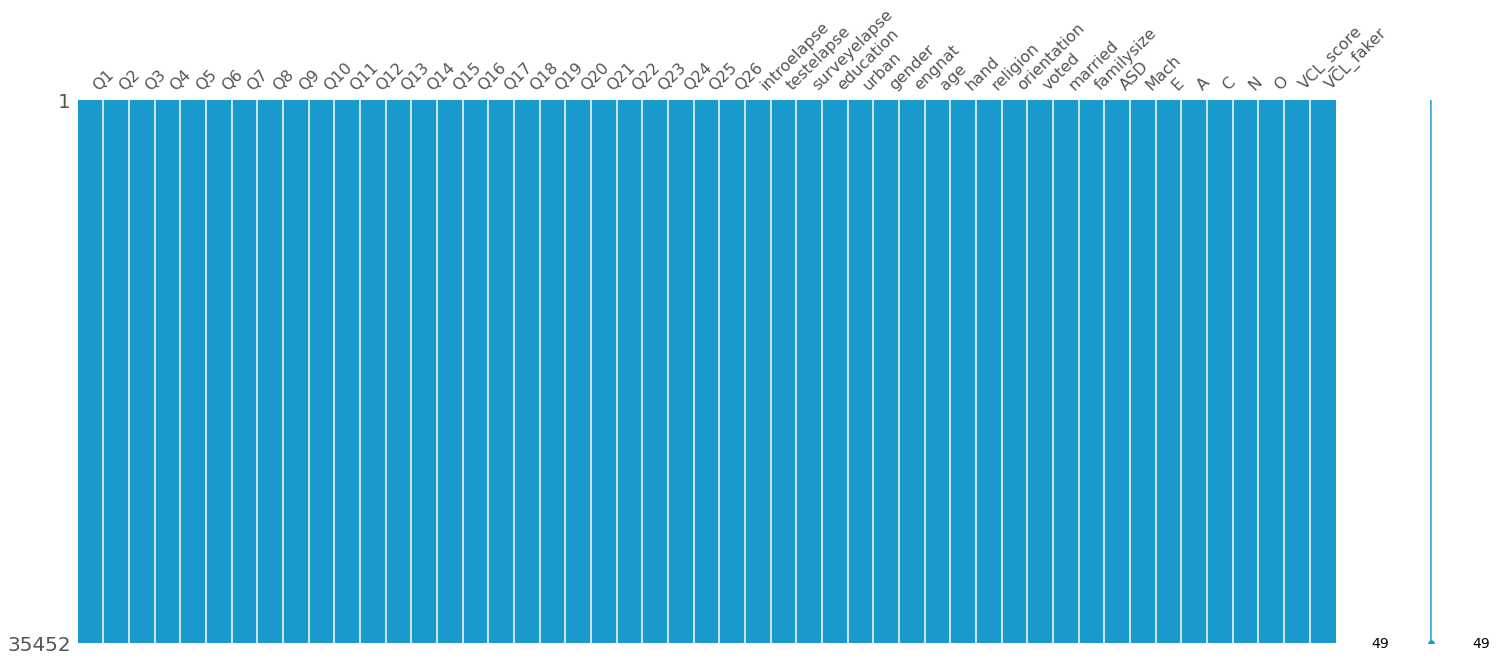

In [11]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

from sklearn.impute import SimpleImputer
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]
for col in q_cols : 
    transformer = SimpleImputer()
    test[col] = transformer.fit_transform(test[col])

test = score_mach(test)
test = score_tipi(test)
test = score_vcl(test)

# # pycaret에 넣기 위해서 일부러 넣어주는 것 
# test['nerdiness'] = 0.00

msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

In [12]:
# train = df.drop(['index', 'country'],axis = 1)
# test =test.drop(['index', 'country'],axis = 1)
# train = train.fillna(0) #test 결측치 0으로 채우기
# test = test.fillna(0)

In [13]:
#train을 target과 feature로 나눠줍니다.
train_x=train.drop(['nerdiness'], axis=1)
train_y=train['nerdiness']

# Train -> Train, Valid 분리

In [14]:
rows = len(train.index)
columns = len(train.columns)

Train = train[:int(rows*0.8)]
Valid = train[int(rows*0.8):]
Valid

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,nerdiness,Mach,E,A,C,N,O,VCL_score,VCL_faker
12000,2.0,4.0,2.0,5.0,2.0,4.0,1.816738,4.0,2.0,5.0,...,2.0,0.0,2.840837,5.0,4.5,4.0,4.5,4.5,12.0,0.0
12001,3.0,5.0,2.0,2.0,4.0,3.0,2.000000,5.0,3.0,1.0,...,2.0,1.0,3.050000,2.5,3.0,4.5,4.5,4.5,11.0,2.0
12002,5.0,3.0,1.0,1.0,5.0,4.0,1.000000,5.0,1.0,1.0,...,2.0,0.0,2.600000,3.0,4.0,5.0,5.0,5.0,9.0,0.0
12003,2.0,4.0,2.0,2.0,4.0,2.0,1.000000,2.0,3.0,2.0,...,2.0,0.0,2.600000,4.0,3.5,4.0,5.0,5.5,10.0,0.0
12004,3.0,5.0,2.0,3.0,5.0,4.0,2.000000,4.0,1.0,1.0,...,2.0,0.0,2.850000,2.5,3.5,4.0,4.0,5.0,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,2.0,3.0,3.0,4.0,2.000000,4.0,3.0,2.0,...,2.0,0.0,3.150000,2.5,4.5,4.5,4.0,4.0,10.0,1.0
14996,5.0,4.0,1.0,2.0,4.0,5.0,1.000000,4.0,2.0,1.0,...,2.0,1.0,2.800000,4.0,5.0,5.5,2.5,5.0,8.0,0.0
14997,4.0,5.0,1.0,1.0,5.0,5.0,1.000000,5.0,2.0,1.0,...,1.0,1.0,3.000000,2.0,4.0,3.5,2.0,4.0,9.0,0.0
14998,5.0,5.0,2.0,1.0,5.0,5.0,1.000000,1.0,1.0,1.0,...,1.0,0.0,2.650000,2.0,6.0,3.5,2.5,5.5,11.0,1.0


In [15]:
x_train = Train.drop(['nerdiness'], axis=1)
y_train = Train['nerdiness']
x_test = Valid.drop(['nerdiness'], axis=1)
y_test = Valid['nerdiness']

In [16]:
# # 학습, 테스트 데이터 분리 (0.7:0.3)
# seed = 2022
# x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=seed, stratify = train_y)

# RandomForest Hyperparameter Tuning 
## final params {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 3000}
랜덤포레스트는 트리 기반의 하이퍼파라미터를 사용하여 하이퍼 파라미터를 튜닝합니다.  
사용되는 주요 파라미터들은 다음과 같습니다.

1. n_estimators
사용되는 Decision Tree의 갯수를 지정  
default : 10  
무작정 트리 갯수를 늘리면 성능 좋아지는 것 대비 시간이 걸릴 수 있음  

2. min_samples_split

노드를 분할하기 위한 최소한의 샘플 데이터수  
→ 과적합을 제어하는데 사용합니다. 값이 작을수록 분할노드가 많아져 과적합 가능성 증가  
default : 2

3. min_samples_leaf

리프노드가 되기 위한 최소한의 샘플 데이터수  
→ 과적합을 제어하는데 사용합니다. 값이 작을수록 과적합 가능성 증가  
default : 1  
불균형 데이터의 경우 특정 클래스 데이터가 극도로 적을 수 있으므로 작은 값으로 설정 필요

4. max_features

최적의 분할을 위해 고려할 피처의 최대 갯수  
default : auto (Decision Tree에서는 default가 None인 것과 차이)  
int형으로 지정 → 피처 갯수  
float형으로 지정 → 전체 갯수의 일정 비율만큼 사용  
sqrt 또는 auto → 전체 피처 중 √(피처 개수) 만큼 선정  
log2 : 전체 피처 중 log2(전체 피처 개수) 만큼 선정  

4. max_depth

트리의 최대 깊이  
default : None → 완벽하게 클래스 값이 결정될 때까지 분할  
또는 데이터 갯수가 min_samples_split보다 작아질 때까지 분할  
깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요  

5. max_leaf_nodes  
리프노드의 최대 갯수
default : None

In [17]:
# model_rf = RandomForestClassifier(random_state = 2022)

In [18]:
# model_param_grid = {'n_estimators' : [3000],
# #           'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [1,2,5,10],
#            'min_samples_split' : [2,4,6,8,10]
#             } # Default(100)대비 큰값으로 Dictionary구성

In [19]:
# model_grid = GridSearchCV(model_rf, param_grid = model_param_grid, scoring="accuracy",n_jobs=-1,verbose=1) #훈련 (장치 사양에 따라 시간이 걸릴 수 있음)
# model_grid.fit(x_train, y_train)

In [20]:
# cv=KFold(n_splits=6, random_state=2022, shuffle=True) #교차검증

In [21]:
# gcv=GridSearchCV(model_rf, param_grid=model_param_grid, cv=cv, scoring='f1', n_jobs=-1)

In [22]:
# gcv.fit(x_train.values,y_train.values)
# print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력

# 최적의 n_estimators를 기반으로 model 생성

In [23]:
model = RandomForestClassifier(n_estimators=3000, min_samples_leaf=2, min_samples_split=2, random_state=2022, n_jobs=-1)

In [24]:
# model.fit(x_train, y_train) #학습

In [25]:
# pred = model.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환

In [26]:
# 8pred = model.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환
# print(roc_auc_score(y_test, pred))

In [27]:
# # 학습결과 평가
# print("Train_Accuracy : ", model.score(x_train, y_train))
# print("Test_Accuracy : ", model.score(x_test, y_test), '\n')

# accuracy = mt.accuracy_score(y_test, rf_pred)
# print("Accuracy :" ,mt.accuracy_score(y_test, rf_pred))

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def stratifiedkfold(train_x, train_y, n_splits=5):
  kfold = StratifiedKFold(n_splits)
  cv_accuracy = []
  n_iter =0

  for train_index, test_index in kfold.split(train_x, train_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
      x_valid, x_test_fold = train_x.iloc[train_index], train_x.iloc[test_index]
      y_valid, y_test_fold = train_y[train_index], train_y[test_index]
      
      model.fit(x_valid, y_valid)
      pred = model.predict(x_test_fold)
      n_iter += 1
      
      accuracy = np.round(accuracy_score(y_test_fold, pred), 4) # 소수점 4자리 반올림
      train_size = x_valid.shape[0]
      test_size = x_test_fold.shape[0]
      
      print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
            .format(n_iter, accuracy, train_size, test_size))
      print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
      cv_accuracy.append(accuracy)
      
  print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [29]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# kfold = StratifiedKFold(n_splits=5)
# cv_accuracy = []
# n_iter =0

# for train_index, test_index in kfold.split(train_x, train_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
#     x_valid, x_test_fold = train_x.iloc[train_index], train_x.iloc[test_index]
#     y_valid, y_test_fold = train_y[train_index], train_y[test_index]
    
#     model.fit(x_valid, y_valid)
#     pred = model.predict(x_test_fold)
#     n_iter += 1
    
#     accuracy = np.round(accuracy_score(y_test_fold, pred), 4) # 소수점 4자리 반올림
#     train_size = x_valid.shape[0]
#     test_size = x_test_fold.shape[0]
    
#     print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
#           .format(n_iter, accuracy, train_size, test_size))
#     print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
#     cv_accuracy.append(accuracy)
    
# print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))
stratifiedkfold(x_train, y_train)


#1 교차 검증 정확도 : 0.7696,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#1 검증 세트 인덱스 : [   0    1    2 ... 2461 2462 2463]

#2 교차 검증 정확도 : 0.7958,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#2 검증 세트 인덱스 : [2315 2320 2324 ... 4843 4845 4847]

#3 교차 검증 정확도 : 0.7729,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#3 검증 세트 인덱스 : [4759 4762 4766 ... 7265 7267 7268]

#4 교차 검증 정확도 : 0.7854,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#4 검증 세트 인덱스 : [7083 7086 7087 ... 9631 9634 9635]

#5 교차 검증 정확도 : 0.7812,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#5 검증 세트 인덱스 : [ 9553  9554  9556 ... 11997 11998 11999]

## 평균 검증 정확도: 0.78098


In [30]:
pred = model.predict_proba(x_test)[:,1]
# 학습결과 평가
print("Train_Accuracy : ", model.score(x_train, y_train))
print("Test_Accuracy : ", model.score(x_test, y_test), '\n')

print(roc_auc_score(y_test, pred))

Train_Accuracy :  0.95475
Test_Accuracy :  0.7713333333333333 

0.8571897417503586


# 전체 train 데이터에 대해 학습

In [31]:
#model2 = RandomForestClassifier(n_estimators=3000, random_state=2022, n_jobs=-1)
model2 = RandomForestClassifier(n_estimators=5000, random_state=2022, n_jobs=-1)

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(train_x, train_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_valid, x_test_fold = train_x.iloc[train_index], train_x.iloc[test_index]
    y_valid, y_test_fold = train_y[train_index], train_y[test_index]
    
    model2.fit(x_valid, y_valid)
    pred = model2.predict(x_test_fold)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test_fold, pred), 4) # 소수점 4자리 반올림
    train_size = x_valid.shape[0]
    test_size = x_test_fold.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.785,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#1 검증 세트 인덱스 : [   0    1    2 ... 3027 3030 3031]

#2 교차 검증 정확도 : 0.804,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#2 검증 세트 인덱스 : [2962 2966 2968 ... 6026 6028 6029]

#3 교차 검증 정확도 : 0.7767,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#3 검증 세트 인덱스 : [5966 5967 5969 ... 9034 9035 9040]

#4 교차 검증 정확도 : 0.802,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#4 검증 세트 인덱스 : [ 8976  8977  8978 ... 12037 12038 12041]

#5 교차 검증 정확도 : 0.7877,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#5 검증 세트 인덱스 : [11961 11962 11964 ... 14997 14998 14999]

## 평균 검증 정확도: 0.79108


In [33]:
pred2 = model2.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환

# 학습결과 평가
print("Train_Accuracy : ", model2.score(x_train, y_train))
print("Test_Accuracy : ", model2.score(x_test, y_test), '\n')

print(roc_auc_score(y_test, pred2))

Train_Accuracy :  0.9998333333333334
Test_Accuracy :  0.7883333333333333 

0.8793779142754662


###breif conclusion:  
k-fold가 더 낫긴함. 근데 0.99면 좀 과적합이 아닐까 우려해봐야하긴함.  
model(=k-fold) better than model2(=no)

# Submission

In [34]:
# 학습한 모델로 예측수행
#test_pred = model.predict(test)
test_pred = model2.predict_proba(test)[:,1] #proba를 통해 확률값으로 변환

In [35]:
submission = pd.read_csv('/content/drive/MyDrive/Dacon/sample_submission.csv')

submission

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
35447,35447,-1
35448,35448,-1
35449,35449,-1
35450,35450,-1


In [36]:
submission["nerdiness"] = test_pred

In [37]:
submission

,index,nerdiness
0,0,0.2584
1,1,0.8528
2,2,0.8510
3,3,0.5682
4,4,0.6572
...,...,...
35447,35447,0.8462
35448,35448,0.7118
35449,35449,0.9306
35450,35450,0.2438


In [38]:
submission.to_csv("/content/drive/MyDrive/Dacon/RandomForest.csv", index = False)